In [1]:
"""
 Copyright (C) 2016 Elvis Teixeira

 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
"""

import numpy as np
import scipy as cp
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
def load_data(file, sep='\s+'):
    return pd.read_csv(file, sep=sep)


def sample_data(data, train_frac):
    copy = data.copy()
    copy.reindex(np.random.permutation(copy.index))
    train_count = int(train_frac * copy.shape[0])
    # yield training set attrs and labels
    yield copy.ix[:train_count,:-1].as_matrix()
    yield copy.ix[:train_count,-1].as_matrix()
    # yield validation set attrs and labels
    yield copy.ix[train_count:,:-1].as_matrix()
    yield copy.ix[train_count:,-1].as_matrix()

In [3]:
def create_means(num_basis, dim=4):
    return np.random.uniform(0.0, 1.0, (num_basis, dim))


def gauss_basis(x, mu):
    t = x - mu
    return np.exp(-3.0*((t.dot(t))**2))


def regression(design, y, lamb):
    lambI = lamb * np.identity(design.shape[1])
    w1 = lambI + design.T.dot(design)
    w2 = np.linalg.inv(w1).dot(design.T)
    return w2.dot(y)


def learn(x, y, lamb, basis, num_basis, means):
    num_attrs = num_basis + 1
    design = np.empty([x.shape[0], num_attrs])
    for i in range(design.shape[0]):
        design[i, 0] = 1.0
        for j in range(1, design.shape[1]):
            design[i, j] = basis(x[i], means[j-1])
    return regression(design, y, lamb)


def predict(w, basis, means, num_basis, x):
    num_attrs = num_basis + 1
    ret = w[0]
    for i in range(1, w.shape[0]):
        ret += w[i] * basis(x, means[i-1])
    return ret


def rms_error(y_predicted, y_real):
    err = 0
    for p, r in zip(y_predicted, y_real):
        err += (p - r)**2
    return np.sqrt(err) / y_real.shape[0]


def training(xt, yt, ntimes, basis, num_basis, means, lamb=0.0):
    rms_err = 0.0
    for i in range(ntimes):
        w = learn(xt, yt, lamb, basis, num_basis, means)
        y_predict = []
        for x in xt:
            y_predict.append(predict(w, basis, means, num_basis, x))
        rms_err += rms_error(y_predict, yt)
    return rms_err/ntimes

In [7]:
def train_basis_number(xt, yt, maxbasis, ntimes, basis, lamb=0.0):
    m_err = []
    for m in range(1, maxbasis):
        means = create_means(m)
        m_err.append(training(xt, yt, ntimes, basis, m, means, lamb))
    return np.array(m_err)


def train_regularization_factor(xt, yt, xv, yv, ntimes, basis, m=5):
    m_train_err = []
    m_valid_err = []
    means = create_means(m)
    lambdas = [l for l in np.arange(0.0, 5.0, 0.05)]
    for l in lambdas:
        m_train_err.append(training(xt, yt, ntimes, basis, m, means, l))
        w = learn(xt, yt, l, basis, m, means)
        m_train_err.append(rms_error(predict(w, basis, means, m, )))
    return np.array(m_err)


# Sample a random training set and a validation set
xt, yt, xv, yv = sample_data(load_data('dataset.txt'), 0.6667)

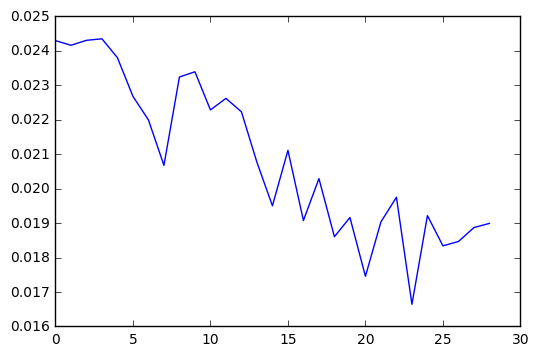

In [8]:
err = train_basis_number(xt, yt, 30, 3, gauss_basis)
plt.plot(err, 'b-')
plt.show()

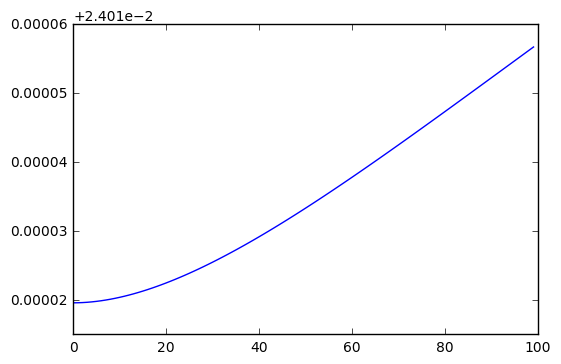

In [9]:
err = train_regularization_factor(xt, yt, 3, gauss_basis)
plt.plot(err, 'b-')
plt.show()